# Using Tensorflow through ONNX:

The ONNX path to getting a TensorRT engine is a high-performance approach to TensorRT conversion that works with a variety of frameworks - including Tensorflow and Tensorflow 2.

TensorRT's ONNX parser is an all-or-nothing parser for ONNX models that ensures an optimal, single TensorRT engine and is great for exporting to the TensorRT API runtimes. ONNX models can be easily generated from Tensorflow models using the ONNX project's keras2onnx and tf2onnx tools.

In this notebook we will take a look at how ONNX models can be generated from a Keras/TF2 ResNet50 model, how we can convert those ONNX models to TensorRT engines using trtexec, and finally how we can use the native Python TensorRT runtime to feed a batch of data into the TRT engine at inference time.

Essentially, we will follow this path to convert and deploy our model:

![Tensorflow+ONNX](./images/tf_onnx.png)

__Use this when:__
- You want the most efficient runtime performance possible out of an automatic parser
- You have a network consisting of mostly supported operations -  including operations and layers that the ONNX parser uniquely supports (Such as RNNs/LSTMs/GRUs)
- You are willing to write custom C++ plugins for any unsupported operations (if your network has any)
- You do not want to use the manual layer builder API

__Checking your GPU status:__

Lets see what GPU hardware we are working with. Our hardware can matter a lot because different cards have different performance profiles and precisions they tend to operate best in. For example, a V100 is relatively strong as FP16 processing vs a T4, which tends to operate best in the INT8 mode.

In [1]:
!nvidia-smi

Wed Jun  9 19:47:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   45C    P0    63W / 300W |   5572MiB / 16155MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

Remember to sucessfully deploy a TensorRT model, you have to make __five key decisions__:

1. __What format should I save my model in?__
2. __What batch size(s) am I running inference at?__
3. __What precision am I running inference at?__
4. __What TensorRT path am I using to convert my model?__
5. __What runtime am I targeting?__

## 1. What format should I save my model in?

Our first step is to load up a pretrained ResNet50 model. This can be done easily using keras.applications - a collection of pretrained image model classifiers that can additionally be used as backbones for detection and other deep learning problems.

We can load up a pretrained classifier with batch size 32 as follows:

In [2]:
from tensorflow.keras.applications import ResNet50

BATCH_SIZE = 32

In [3]:
model = ResNet50(weights='imagenet')

For the purposes of checking our non-optimized model, we can use a dummy batch of data to verify our performance and the consistency of our results across precisions. 224x224 RGB images are a common  format, so lets generate a batch of them.

Once we generate a batch of them, we will feed it through the model using .predict() to "warm up" the model. The first batch you feed through a deep learning model often takes a lot longer as just-in-time compilation and other runtime optimizations are performed. Once you get that first batch through, further performance tends to be more consistent.

To create a test batch, we will simply repeat one open-source dog image from http://www.dog.ceo

In [4]:
import numpy as np
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt

url='https://images.dog.ceo/breeds/retriever-golden/n02099601_3004.jpg'
img = resize(io.imread(url), (224, 224))
input_batch = 255*np.array(np.repeat(np.expand_dims(np.array(img, dtype=np.float32), axis=0), BATCH_SIZE, axis=0), dtype=np.float32)

input_batch.shape

(32, 224, 224, 3)

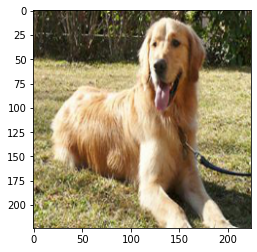

In [5]:
plt.imshow(input_batch[0]/255)

The image above is a Golden Retriever, class 207 in ImageNet. So we look for class 207  in the top 5 predictions to verify our model works as intended:

In [6]:
predictions = model.predict(input_batch) # warm up
indices = (-predictions[0]).argsort()[:5]
print("Class | Probability (out of 1)")
list(zip(indices, predictions[0][indices]))

Class | Probability (out of 1)


[(160, 0.32290387),
 (169, 0.266499),
 (212, 0.16812354),
 (170, 0.07066823),
 (207, 0.03341851)]

Labels 150 to 275 or so are dogs in ImageNet, so look for those as other common predictions in addition to our correct 207 class.

__Baseline Timing:__

Once we have warmed up our non-optimized model, we can get a rough timing estimate of our model using %%timeit, which runs the cell several times and reports timing information.

Lets take a look at how long our model takes to run at baseline before doing any TensorRT optimization:

In [7]:
%%timeit

result = model.predict_on_batch(input_batch) # Check default performance

46.8 ms ± 514 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Okay - now that we have a baseline model, lets convert it to the format TensorRT understands best: ONNX. 

__Convert Keras model to ONNX intermediate model and save:__

The ONNX format is a framework-agnostic way of describing and saving the structure and state of deep learning models. We can convert Tensorflow 2 Keras models to ONNX using the keras2onnx tool provided by the ONNX project. (You can find the ONNX project here: https://onnx.ai or on GitHub here: https://github.com/onnx/onnx)

In [8]:
import onnx, keras2onnx

Converting a model with default parameters to an ONNX model is fairly straightforward:

In [9]:
model.save('my_model')
!python -m tf2onnx.convert --saved-model my_model --output temp.onnx
onnx_model = onnx.load_model('temp.onnx')

# This can also be done with keras2onnx:
# onnx_model = keras2onnx.convert_keras(model, model.name)

INFO:tensorflow:Assets written to: my_model/assets
2021-06-09 19:48:30.462380: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2021-06-09 19:48:31.938818: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-06-09 19:48:31.939684: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-06-09 19:48:32.010614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1747] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: Tesla V100-DGXS-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2

That said, we do need to make one change for our model to work with TensorRT. Keras by default uses a dynamic input shape in its networks - where it can handle arbitrary batch sizes at every update. While TensorRT can do this, it requires extra configuration. 

Instead, we will just set the input size to be fixed to our batch size. This will work with TensorRT out of the box!

__Configure ONNX File Batch Size:__

__Note:__ We need to do two things to set our batch size with ONNX. The first is to modify our ONNX file to change its default batch size to our target batch size. The second is setting our converter to use the __explicit batch__ mode, which will use this default batch size as our final batch size.

In [10]:
inputs = onnx_model.graph.input
for input in inputs:
    dim1 = input.type.tensor_type.shape.dim[0]
    dim1.dim_value = BATCH_SIZE

__Save Model:__

In [11]:
model_name = "resnet50_onnx_model.onnx"
onnx.save_model(onnx_model, model_name)
print("Done saving!")

Done saving!


Once we get our model into ONNX format, we can convert it efficiently using TensorRT. For this, TensorRT needs exclusive access to your GPU. If you so much as import Tensorflow, it will generally consume all of your GPU memory. To get around this, before moving on go ahead and shut down this notebook and restart it. (You can do this in the menu: Kernel -> Restart Kernel)

Make sure not to import Tensorflow at any point after restarting the runtime! 

(The following cell is a quick shortcut to make your notebook restart:)

In [ ]:
import os, time
print("Restarting kernel  in three seconds...")
time.sleep(3)
print("Restarting kernel now")
os._exit(0) # Shut down all kernels so TRT doesn't fight with Tensorflow for GPU memory - TF monopolizes all GPU memory by default

Restarting kernel  in three seconds...


## 2. What batch size(s) am I running inference at?

We have actually already set our inference batch size - see the note above in section 1!

We are going to set our target batch size to a fixed size of 32.

In [1]:
BATCH_SIZE = 32

We need to do two things to set our batch size to a fixed batch size with ONNX: 

1. Modify our ONNX file to change its default batch size to our target batch size, which we did above.
2. Use the trtexec --explicitBatch flag, which we also did above.

## 3. What precision am I running inference at?

Now, we have a converted TensorRT engine. Great! That means we are ready to load it into the native Python TensorRT runtime. This runtime strikes a balance between the ease of use of the high level Python runtimes and the low level C++ runtimes.

First, as before, lets create a dummy batch. Importantly, by default TensorRT will use the input precision you give it as the default precision for the rest of the network. 

Remember that lower precisions than FP32 tend to run faster. There are two common reduced precision modes - FP16 and INT8. Graphics cards that are designed to do inference well often have an affinity for one of these two types. This guide was developed on an NVIDIA V100, which favors FP16, so we will use that here by default. INT8 is a more complicated process that requires a calibration step.

In [2]:
import numpy as np

USE_FP16 = True

target_dtype = np.float16 if USE_FP16 else np.float32

We generate a batch of repeating Golden Retriever images, as before. Make sure that for TensorRT the image is resized to the size your model expects. Tensorflow and TensorRT have different behavior for handling 'oversized' images - so this is a safe way of ensuring consistent results across the two.

In [3]:
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt

url='https://images.dog.ceo/breeds/retriever-golden/n02099601_3004.jpg'
img = resize(io.imread(url), (224, 224))
input_batch = 255*np.array(np.repeat(np.expand_dims(np.array(img, dtype=np.float32), axis=0), BATCH_SIZE, axis=0), dtype=np.float32)

Only we must now cast the input batch to the proper FP32/FP16 precision:

In [4]:
input_batch = input_batch.astype(target_dtype)

## 4. What TensorRT path am I using to convert my model?

TensorRT is able to take ONNX models and convert them entirely into a single, efficient TensorRT engine. Restart your Jupyter kernel, and then start here!

We can use trtexec, a command line tool for working with TensorRT, in order to convert an ONNX model to an engine file.

To convert the model we saved in the previous steps, we need to point to the ONNX file, give trtexec a name to save the engine as, and last specify that we want to use a fixed batch size instead of a dynamic one.

__Remember to shut down all Jupyter notebooks and restart your Jupyter kernel after "1. What format should I save my model in?" - otherwise this cell will crash as TensorRT competes with Tensorflow for GPU memory:__

In [5]:
# May need to shut down all kernels and restart before this - otherwise you might get cuDNN initialization errors:
if USE_FP16:
    !trtexec --onnx=resnet50_onnx_model.onnx --saveEngine=resnet_engine.trt  --explicitBatch --inputIOFormats=fp16:chw --outputIOFormats=fp16:chw --fp16
else:
    !trtexec --onnx=resnet50_onnx_model.onnx --saveEngine=resnet_engine.trt  --explicitBatch

&&&& RUNNING TensorRT.trtexec # trtexec --onnx=resnet50_onnx_model.onnx --saveEngine=resnet_engine.trt --explicitBatch --inputIOFormats=fp16:chw --outputIOFormats=fp16:chw --fp16
[06/09/2021-19:49:25] [I] === Model Options ===
[06/09/2021-19:49:25] [I] Format: ONNX
[06/09/2021-19:49:25] [I] Model: resnet50_onnx_model.onnx
[06/09/2021-19:49:25] [I] Output:
[06/09/2021-19:49:25] [I] === Build Options ===
[06/09/2021-19:49:25] [I] Max batch: explicit
[06/09/2021-19:49:25] [I] Workspace: 16 MiB
[06/09/2021-19:49:25] [I] minTiming: 1
[06/09/2021-19:49:25] [I] avgTiming: 8
[06/09/2021-19:49:25] [I] Precision: FP32+FP16
[06/09/2021-19:49:25] [I] Calibration: 
[06/09/2021-19:49:25] [I] Refit: Disabled
[06/09/2021-19:49:25] [I] Safe mode: Disabled
[06/09/2021-19:49:25] [I] Save engine: resnet_engine.trt
[06/09/2021-19:49:25] [I] Load engine: 
[06/09/2021-19:49:25] [I] Builder Cache: Enabled
[06/09/2021-19:49:25] [I] NVTX verbosity: 0
[06/09/2021-19:49:25] [I] Tactic sources: Using default tacti


-

__The trtexec Logs:__

Above, trtexec does a lot of things! Some important things to note:

__First__, _"PASSED"_ is what you want to see in the last line of the log above. We can see our conversion was successful!

__Second__, can see the resnet_engine.trt engine file has indeed been successfully created: 

In [6]:
!ls -la

total 508284
drwxrwxr-x 8 1000 1000      4096 Jun  9 19:49  .
drwxrwxr-x 5 1000 1000      4096 Apr  5 23:28  ..
drwxr-xr-x 2 root root      4096 Apr  6 01:13  .ipynb_checkpoints
-rw-rw-r-- 1 1000 1000     34748 Jun  9 19:46 '0. Running This Guide.ipynb'
-rw-rw-r-- 1 1000 1000    502649 Apr  5 23:28 '1. Introduction.ipynb'
-rw-rw-r-- 1 1000 1000     23645 Apr  5 23:28 '2. Using the Tensorflow TensorRT Integration.ipynb'
-rw-rw-r-- 1 1000 1000    210995 Jun  9 19:49 '3. Using Tensorflow 2 through ONNX.ipynb'
-rw-rw-r-- 1 1000 1000    334050 Jun  9 19:17 '4. Using PyTorch through ONNX.ipynb'
-rw-rw-r-- 1 1000 1000      7052 Apr  5 23:28 '5. Understanding TensorRT Runtimes.ipynb'
drwxrwxr-x 2 1000 1000      4096 Apr  5 23:28 'Additional Examples'
drwxr-xr-x 2 root root      4096 Apr  5 23:28  Getting_Started
drwxr-xr-x 2 root root      4096 Apr  6 01:09  __pycache__
-rw-rw-r-- 1 1000 1000      4085 Apr  5 23:28  helper.py
drwxrwxr-x 2 1000 1000      4096 Apr  5 23:28  images
drwxr-xr-x 4 r

__Third__, you can see timing details above using trtexec - these are in the ideal case with no overhead. Depending on how you run your model, a considerable amount of overhead can be added to this. We can do timing in our Python runtime below - but keep in mind performing C++ inference would likely be faster.

## 5. What TensorRT runtime am I targeting?

We want to run our TensorRT inference in Python - so the TensorRT Python API is a great way of testing our model out in Jupyter, and is still quite performant.

To use it, we need to do a few steps:

__Load our engine into a tensorrt.Runtime:__

In [7]:
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit

f = open("resnet_engine.trt", "rb")
runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING)) 

engine = runtime.deserialize_cuda_engine(f.read())
context = engine.create_execution_context()

Note: if this cell is having issues, restarting all Jupyter kernels and rerunning only the batch size and precision cells above before trying again often helps

__Allocate input and output memory, give TRT pointers (bindings) to it:__

d_input and d_output refer to the memory regions on our 'device' (aka GPU) - as opposed to memory on our normal RAM, where Python holds its variables (such as 'output' below).

In [8]:
output = np.empty([BATCH_SIZE, 1000], dtype = target_dtype) # Need to set output dtype to FP16 to enable FP16

# Allocate device memory
d_input = cuda.mem_alloc(1 * input_batch.nbytes)
d_output = cuda.mem_alloc(1 * output.nbytes)

bindings = [int(d_input), int(d_output)]

stream = cuda.Stream()

__Set up prediction function:__

This involves a copy from CPU RAM to GPU VRAM, executing the model, then copying the results back from GPU VRAM to CPU RAM:

In [9]:
def predict(batch): # result gets copied into output
    # Transfer input data to device
    cuda.memcpy_htod_async(d_input, batch, stream)
    # Execute model
    context.execute_async_v2(bindings, stream.handle, None)
    # Transfer predictions back
    cuda.memcpy_dtoh_async(output, d_output, stream)
    # Syncronize threads
    stream.synchronize()
    
    return output

This is all we need to run predictions using our TensorRT engine in a Python runtime!

In [10]:
print("Warming up...")

trt_predictions = predict(input_batch).astype(np.float32)

print("Done warming up!")

Warming up...
Done warming up!


In [11]:
indices = (-trt_predictions[0]).argsort()[:5]
print("Class | Probability (out of 1)")
list(zip(indices, trt_predictions[0][indices]))

Class | Probability (out of 1)


[(160, 0.3112793),
 (169, 0.27026367),
 (212, 0.17321777),
 (170, 0.07165527),
 (207, 0.033843994)]

Note that we have recovered our same predictions as before!

## Performance Comparison:

Last, we can see how quickly we can feed a singular batch to TensorRT, which we can compare to our original Tensorflow experiment from earlier.

We use the %%timeit Jupyter magic again. Note that %%timeit is fairly rough, and for any actual benchmarking better controlled testing is required - preferably outside of Jupyter.

In [12]:
%%timeit

_ = predict(input_batch) # Check TRT performance

6.41 ms ± 846 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Next Steps:

<h4> Profiling </h4>

This is a great next step for further optimizing and debugging models you are working on productionizing

You can find it here: https://docs.nvidia.com/deeplearning/tensorrt/best-practices/index.html

<h4>  TRT Dev Docs </h4>

Main documentation page for the ONNX, layer builder, C++, and legacy APIs

You can find it here: https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html

<h4>  TRT OSS GitHub </h4>

Contains OSS TRT components, sample applications, and plugin examples

You can find it here: https://github.com/NVIDIA/TensorRT


#### TRT Supported Layers:

https://github.com/NVIDIA/TensorRT/tree/main/samples/opensource/samplePlugin

#### TRT ONNX Plugin Example:

https://docs.nvidia.com/deeplearning/tensorrt/support-matrix/index.html#layers-precision-matrix
